## Analysis of Nottingham Power Rig in MrOS V1 Data (EDA3-V1-NP.ipynb)
**Form Example**: [Nottingham Power Rig Form](np_form.png).

This form is the result of a patient using the Nottingham Power Rig to measure  is a device used to measure Lower Extremity Power (LEP). The estimate of power is obtained by having the participant seated in an adjustable seat and pressing a foot petal until the leg is extended.

LEP is a measure of the ability of the lower limbs to generate force and perform work. It is often used as an indicator of functional capacity and physical performance in various populations, including older adults. While LEP itself may not directly predict osteoporotic fractures, it is linked to factors that contribute to fracture risk.


#### 1. [Installation and Importing of Libraries](#eda_import)
#### 2. [Retreival of Data](#eda_retrieval)
#### 3. [Data Cleanup](#eda_cleanup)
#### 4. [Handling of NAs](#eda_na)
#### 5. [Descriptive Statistics and Visualizations](#eda_describe)
#### 6. [Write a CSV of cleaned data](#eda_csv)

### <a name="eda_import"></a>Installation and Importing of Libraries
In order to both explore and visualize the data, it's necessary for us to load various libraries.  In addition to loading already pre-installed libraries, we've also had to install seaborn for plotting. 

In [3]:
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.7/site-packages (0.12.2)


In [4]:
##import libraries required for analysis
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from sklearn.decomposition import PCA
import mpl_toolkits.mplot3d
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
import psycopg2
import sqlalchemy
import getpass
import pandas as pd 

### <a name="eda_retrieval"></a>Retreival of Data
The data needs to be retrieved from the Postgres database and stored in a dataframe for us to begin analyzing.


In [5]:
##Connect to Postgre
user = "dtfp3"
host = "pgsql.dsa.lan"
database = "casestdysu23t03"
password = getpass.getpass()
connectionstring = "postgresql://" + user + ":" + password + "@" + host + "/" + database
engine = sqlalchemy.create_engine(connectionstring)
connection = None

try:
    connection = engine.connect()
except Exception as err:
    print("An error has occurred trying to connect: {}".format(err))

del password

········


In [6]:
query = "SELECT * FROM public.v1_form_np"
np = pd.read_sql_query(query, con=connection)

### <a name="eda_cleanup"></a>Data Cleanup
Now that the data has been retrieved from the database, let's do some exploration and cleanup. 

We'll need to first understand the dimensions of our data and then it'll be helpful to make it more readable. 

In [7]:
print(np['ID'].dtype)
print(np.head())

object
       ID NPSTAFF  NPHIPREP  NPHIPSD  NPSEAT  NPLFST  NPSEATLT  NPLEFTNO  \
0  BI0001    BI09       0.0      NaN    83.5     0.0       NaN       NaN   
1  BI0002    BI09       0.0      NaN    86.0     0.0       NaN       NaN   
2  BI0003    BI09       0.0      NaN    90.8     0.0       NaN       NaN   
3  BI0004    BI09       0.0      NaN    96.0     0.0       NaN       NaN   
4  BI0005    BI09       0.0      NaN    82.5     0.0       NaN       NaN   

   NPLEFT1  NPLEFT6  ...  NPRIGHT2  NPRIGHT7  NPRIGHT9  NPRMAX  NPLMAX  \
0     74.7    140.2  ...     128.1     181.9     197.4   197.4   156.9   
1    102.5    137.6  ...     158.4     189.4     201.6   201.6   173.0   
2    189.4    113.4  ...     169.6     205.9     189.4   219.5   226.8   
3    155.4    219.5  ...     193.4     164.7     237.0   237.0   259.4   
4     96.1    120.4  ...      92.4     119.4     135.2   135.2   132.7   

   NPOMAX  NPREASL  NPREASR  NPREASB   NP  
0   197.4      0.0      0.0      0.0  1.0  
1  

In [8]:
# Iterating over the column names so we can then make human readable versions
for column in np.columns:
    print(column)

ID
NPSTAFF
NPHIPREP
NPHIPSD
NPSEAT
NPLFST
NPSEATLT
NPLEFTNO
NPLEFT1
NPLEFT6
NPLEFT4
NPLEFT5
NPLEFT3
NPLEFT8
NPLEFT2
NPLEFT7
NPLEFT9
NPRGTNO
NPRIGHT1
NPRIGHT6
NPRIGHT4
NPRIGHT5
NPRIGHT3
NPRIGHT8
NPRIGHT2
NPRIGHT7
NPRIGHT9
NPRMAX
NPLMAX
NPOMAX
NPREASL
NPREASR
NPREASB
NP


In [9]:
# I've opted not to rename the columns since it made the analysis below easier.  However, these labels were used as reference. 

## Create a dictionary mapping old names to new names
# name_mapping = {
#   'ID': 'Participant ID',
#   'NPSTAFF': 'Staff ID',
#     'NPHIPREP': 'NPHIPREP Hip Repositioning Test',
#     'NPHIPSD': 'NPHIPSD Hip Standard Deviation',
#     'NPSEAT': 'NPSEAT Seated Measurement',
#     'NPLFST': 'NPLFST Left Foot Measurement',
#     'NPSEATLT': 'NPSEATLT Seat Left Measurement',
#     'NPLEFTNO': 'NPLEFTNO Left Leg Extension Normal',
#     'NPLEFT1': 'NPLEFT1 Left Leg Extension Trial 1',
#     'NPLEFT6': 'NPLEFT6 Left Leg Extension Trial 6',
#     'NPLEFT4': 'NPLEFT4 Left Leg Extension Trial 4',
#     'NPLEFT5': 'NPLEFT5 Left Leg Extension Trial 5',
#     'NPLEFT3': 'NPLEFT3 Left Leg Extension Trial 3',
#     'NPLEFT8': 'NPLEFT8 Left Leg Extension Trial 8',
#     'NPLEFT2': 'NPLEFT2 Left Leg Extension Trial 2',
#     'NPLEFT7': 'NPLEFT7 Left Leg Extension Trial 7',
#     'NPLEFT9': 'NPLEFT9 Left Leg Extension Trial 9',
#     'NPRGTNO': 'NPRGTNO Right Leg Extension Normal',
#     'NPRIGHT1': 'NPRIGHT1 Right Leg Extension Trial 1',
#     'NPRIGHT6': 'NPRIGHT6 Right Leg Extension Trial 6',
#     'NPRIGHT4': 'NPRIGHT4 Right Leg Extension Trial 4',
#     'NPRIGHT5': 'NPRIGHT5 Right Leg Extension Trial 5',
#     'NPRIGHT3': 'NPRIGHT3 Right Leg Extension Trial 3',
#     'NPRIGHT8': 'NPRIGHT8 Right Leg Extension Trial 8',
#     'NPRIGHT2': 'NPRIGHT2 Right Leg Extension Trial 2',
#     'NPRIGHT7': 'NPRIGHT7 Right Leg Extension Trial 7',
#     'NPRIGHT9': 'NPRIGHT9 Right Leg Extension Trial 9',
#     'NPRMAX': 'NPRMAX Maximum Right Leg Extension',
#     'NPLMAX': 'NPLMAX Maximum Left Leg Extension',
#     'NPOMAX': 'NPOMAX Maximum Overall Leg Extension',
#     'NPREASL': 'NPREASL Left Knee Extension Force',
#     'NPREASR': 'NPREASR Right Knee Extension Force',
#     'NPREASB': 'NPREASB Bilateral Knee Extension Force'
#     }

# # Rename columns
# np.rename(columns=name_mapping, inplace=True)

In [10]:
np

,ID,NPSTAFF,NPHIPREP,NPHIPSD,NPSEAT,NPLFST,NPSEATLT,NPLEFTNO,NPLEFT1,NPLEFT6,...,NPRIGHT2,NPRIGHT7,NPRIGHT9,NPRMAX,NPLMAX,NPOMAX,NPREASL,NPREASR,NPREASB,NP
0,BI0001,BI09,0.0,NaN,83.5,0.0,NaN,NaN,74.7,140.2,...,128.1,181.9,197.4,197.4,156.9,197.4,0.0,0.0,0.0,1.0
1,BI0002,BI09,0.0,NaN,86.0,0.0,NaN,NaN,102.5,137.6,...,158.4,189.4,201.6,201.6,173.0,201.6,0.0,0.0,0.0,1.0
2,BI0003,BI09,0.0,NaN,90.8,0.0,NaN,NaN,189.4,113.4,...,169.6,205.9,189.4,219.5,226.8,226.8,0.0,0.0,0.0,1.0
3,BI0004,BI09,0.0,NaN,96.0,0.0,NaN,NaN,155.4,219.5,...,193.4,164.7,237.0,237.0,259.4,259.4,0.0,0.0,0.0,1.0
4,BI0005,BI09,0.0,NaN,82.5,0.0,NaN,NaN,96.1,120.4,...,92.4,119.4,135.2,135.2,132.7,135.2,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5989,SD9014,SD26,0.0,NaN,89.3,0.0,NaN,NaN,160.9,188.2,...,149.3,170.5,173.9,184.5,200.1,200.1,0.0,0.0,0.0,1.0
5990,SD9015,SD04,0.0,NaN,88.0,0.0,NaN,NaN,192.1,256.2,...,232.0,304.9,297.7,312.3,262.1,312.3,0.0,0.0,0.0,1.0
5991,SD9016,SD26,0.0,NaN,94.4,0.0,NaN,NaN,215.2,247.8,...,239.7,253.4,250.6,253.4,247.8,253.4,0.0,0.0,0.0,1.0
5992,SD9017,SD26,0.0,NaN,98.8,0.0,NaN,NaN,186.4,215.2,...,200.1,219.9,247.8,247.8,247.8,247.8,0.0,0.0,0.0,1.0


In [11]:
np = np.drop('NP', axis=1)
np_with_nulls = np

### <a name="eda_na"></a>Exploration of NA Values
Now, we need to understand how much incomplete data we have. 

The nulls stood out during analysis are: 
 - Hip Standard Deviation (NPHIPSD): There were 14 participants which had a hip replacement in the last six months
 - Seat Left Measurement (NPSEATLT): A total of 86 participants used a different seat position for their left side
 - Left Leg Extension Normal (NPLEFTNO): This is part of a chained response and a null indicates that the participant proceeded with the testing.  If this is valued, then the subsequent **left** leg extension trials would be null
   - 1 = Attempted but unable
   - 2 = Did not attempt
   - 3 = Refused 
 - Right Leg Extension Normal (NPRGTNO): This is part of a chained response and a null indicates that the participant proceeded with the testing.  If this is valued, then the subsequent **right** leg extension trials would be null
   - 1 = Attempted but unable
   - 2 = Did not attempt
   - 3 = Refused 

In [12]:
pd.set_option('display.max_rows', None)
print(pd.DataFrame(np.isna().sum(), columns=['Missing Values']))
pd.reset_option('display.max_rows')

          Missing Values
ID                     0
NPSTAFF                0
NPHIPREP              42
NPHIPSD             5980
NPSEAT               576
NPLFST               550
NPSEATLT            5908
NPLEFTNO            5393
NPLEFT1              594
NPLEFT6              633
NPLEFT4              617
NPLEFT5              626
NPLEFT3              606
NPLEFT8              639
NPLEFT2              600
NPLEFT7              637
NPLEFT9              642
NPRGTNO             5377
NPRIGHT1             607
NPRIGHT6             646
NPRIGHT4             629
NPRIGHT5             638
NPRIGHT3             619
NPRIGHT8             657
NPRIGHT2             614
NPRIGHT7             653
NPRIGHT9             662
NPRMAX               606
NPLMAX               593
NPOMAX               552
NPREASL                4
NPREASR                3
NPREASB                3


In [13]:
# replace missing values in the specified columns with 0
cols_to_zero = ['NPHIPSD','NPHIPREP','NPSEAT','NPLFST','NPSEATLT','NPLEFTNO','NPLEFT1','NPLEFT6','NPLEFT4','NPLEFT5',
                'NPLEFT3','NPLEFT8','NPLEFT2','NPLEFT7','NPLEFT9','NPRGTNO','NPRIGHT1','NPRIGHT6','NPRIGHT4','NPRIGHT5',
                'NPRIGHT3','NPRIGHT8','NPRIGHT2','NPRIGHT7','NPRIGHT9','NPRMAX','NPLMAX','NPOMAX','NPREASL','NPREASR',
                'NPREASB']

np[cols_to_zero] = np[cols_to_zero].fillna(0)

In [14]:
pd.set_option('display.max_rows', None)
print(pd.DataFrame(np.isna().sum(), columns=['Missing Values']))
pd.reset_option('display.max_rows')

          Missing Values
ID                     0
NPSTAFF                0
NPHIPREP               0
NPHIPSD                0
NPSEAT                 0
NPLFST                 0
NPSEATLT               0
NPLEFTNO               0
NPLEFT1                0
NPLEFT6                0
NPLEFT4                0
NPLEFT5                0
NPLEFT3                0
NPLEFT8                0
NPLEFT2                0
NPLEFT7                0
NPLEFT9                0
NPRGTNO                0
NPRIGHT1               0
NPRIGHT6               0
NPRIGHT4               0
NPRIGHT5               0
NPRIGHT3               0
NPRIGHT8               0
NPRIGHT2               0
NPRIGHT7               0
NPRIGHT9               0
NPRMAX                 0
NPLMAX                 0
NPOMAX                 0
NPREASL                0
NPREASR                0
NPREASB                0


In [15]:
np.describe().T

,count,mean,std,min,25%,50%,75%,max
NPHIPREP,5994.0,0.002336,0.048276,0.0,0.000,0.00,0.0,1.0
NPHIPSD,5994.0,0.003670,0.079544,0.0,0.000,0.00,0.0,2.0
NPSEAT,5994.0,89.558525,30.362336,0.0,90.600,99.50,104.5,150.0
NPLFST,5994.0,0.014348,0.118929,0.0,0.000,0.00,0.0,1.0
NPSEATLT,5994.0,1.419119,11.790875,0.0,0.000,0.00,0.0,116.2
NPLEFTNO,5994.0,0.210043,0.645170,0.0,0.000,0.00,0.0,3.0
NPLEFT1,5994.0,121.719136,64.716612,0.0,82.250,123.95,165.6,391.3
NPLEFT6,5994.0,160.725225,79.205882,0.0,119.500,168.50,213.0,425.8
NPLEFT4,5994.0,153.763864,76.124316,0.0,114.300,160.10,204.3,439.8
NPLEFT5,5994.0,157.923023,77.681648,0.0,117.900,164.70,210.4,412.4


<a name="eda_describe"></a><h3> Descriptive Statistics and Visualizations </h3>
Below are a set of descriptive statistics meant to familiarize the audience

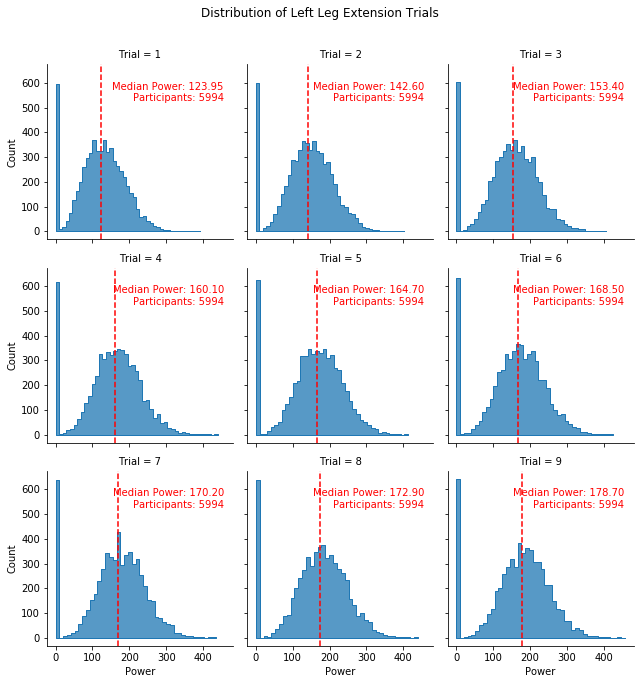

In [16]:
# Combine the left and right leg extension trial data into a single DataFrame
leg_extension_trials = np[['NPLEFT1', 'NPLEFT2', 'NPLEFT3', 'NPLEFT4', 'NPLEFT5', 'NPLEFT6', 'NPLEFT7', 'NPLEFT8', 'NPLEFT9']].melt(var_name='Leg', value_name='Left Leg NP')
leg_extension_trials['Trial'] = leg_extension_trials['Leg'].str.extract('(\d+)').astype(int)

# Create a FacetGrid with labels and title
g = sns.FacetGrid(leg_extension_trials, col='Trial', col_wrap=3)
g.map(sns.histplot, 'Left Leg NP', element='step')
g.set_axis_labels('Power', 'Count')
g.fig.suptitle('Distribution of Left Leg Extension Trials', y=1.05)

# Getting fancy with median power and non-null values shown on each plot
for ax, trial_number in zip(g.axes, leg_extension_trials['Trial'].unique()):
    trial_data = leg_extension_trials[leg_extension_trials['Trial'] == trial_number]['Left Leg NP']
    median_power = trial_data.median()
    non_null_count = trial_data.count()
    ax.axvline(median_power, color='red', linestyle='--')
    ax.text(0.95, 0.9, f'Median Power: {median_power:.2f}\nParticipants: {non_null_count}', transform=ax.transAxes, ha='right', va='top', color='red')

plt.show()

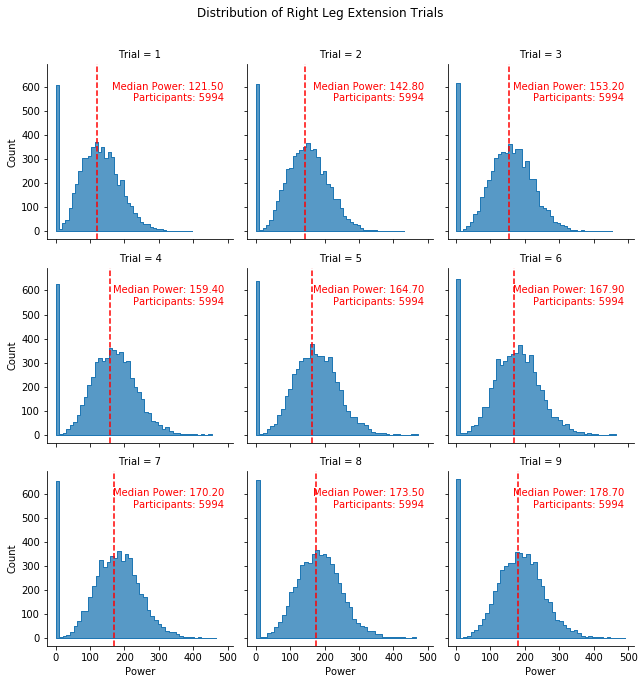

In [17]:
# Right leg extension trial data into a single DataFrame
leg_extension_trials = np[[ 'NPRIGHT1', 'NPRIGHT2', 'NPRIGHT3', 'NPRIGHT4', 'NPRIGHT5', 'NPRIGHT6', 'NPRIGHT7', 'NPRIGHT8', 'NPRIGHT9']].melt(var_name='Leg', value_name='Right Leg NP')
leg_extension_trials['Trial'] = leg_extension_trials['Leg'].str.extract('(\d+)').astype(int)

# Create a FacetGrid with labels and title
g = sns.FacetGrid(leg_extension_trials, col='Trial', col_wrap=3)
g.map(sns.histplot, 'Right Leg NP', element='step')
g.set_axis_labels('Power', 'Count')
g.fig.suptitle('Distribution of Right Leg Extension Trials', y=1.05)

# Getting fancy with median power shown on each plot 
for ax, trial_number in zip(g.axes, leg_extension_trials['Trial'].unique()):
    trial_data = leg_extension_trials[leg_extension_trials['Trial'] == trial_number]['Right Leg NP']
    median_power = trial_data.median()
    non_null_count = trial_data.count()
    ax.axvline(median_power, color='red', linestyle='--')
    ax.text(0.95, 0.9, f'Median Power: {median_power:.2f}\nParticipants: {non_null_count}', transform=ax.transAxes, ha='right', va='top', color='red')

plt.show()

For both left and right leg trials, the majority of individuals that started were able to finish.  In addition, we see a significant increase in power as the trails continue.  

### <a name="eda_csv"></a>Write CSV

In [19]:
# Define the file path and name
file_path_without_nulls = "/dsa/groups/casestudy2023su/team03/model_data/NP_results.csv"
file_path_with_nulls = "/dsa/groups/casestudy2023su/team03/model_data/null_included/NP_results_with_nulls.csv"

# Export the DataFrame to CSV
np.to_csv(file_path_without_nulls, index=False)
np_with_nulls.to_csv(file_path_with_nulls, index=False)

# Set file permissions to 777
os.chmod(file_path_without_nulls, 0o777)
os.chmod(file_path_with_nulls, 0o777)

print("DataFrame exported to CSVs with 777 permissions successfully!")

DataFrame exported to CSVs with 777 permissions successfully!
